In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [20]:
base_dir = "/storage/vbsjjlnu/VBSjjlnu_v7"
version = "v2"

datasets  = ["dnninputs_2016_v2","dnninputs_2017_v2","dnninputs_2018_v2"]

cut     = "boost_sig"
if "res" in cut: 
    phasespace="resolved" 
else:
    phasespace='boosted'
    

output_dir = os.path.join(base_dir, "FullRun2_v7", cut, "samples/" + version)

samples_dirs = [os.path.join(base_dir, p) for p in datasets]

lumi = { 2016: 35.867, 2017: 41.5 , 2018: 59.74}

In [21]:
output_dir

'/storage/vbsjjlnu/VBSjjlnu_v7/FullRun2_v7/boost_sig/samples/v2'

In [22]:
samples_dirs

['/storage/vbsjjlnu/VBSjjlnu_v7/dnninputs_2016_v2',
 '/storage/vbsjjlnu/VBSjjlnu_v7/dnninputs_2017_v2',
 '/storage/vbsjjlnu/VBSjjlnu_v7/dnninputs_2018_v2']

In [23]:
signal = "VBS"
sample_names = ["Wjets_HT", "VBS", "DY", "top", "VV", "VBF-V", "VVV","Vg", "VgS", "Fake"]

samples = {}

for samples_dir in samples_dirs:
    for sample in sample_names:
        print(samples_dir, sample)
        f1 = f"{samples_dir}/dataframe_{sample}_{cut}_ele_dnn_inputs_{phasespace}.csv"
        f2 = f"{samples_dir}/dataframe_{sample}_{cut}_mu_dnn_inputs_{phasespace}.csv"
        if not os.path.exists(f1):
            break
        eledf = pd.read_csv(f1,sep=',')
        mudf = pd.read_csv(f2,sep=',')
        eledf['lep_flavour'] = 1
        mudf['lep_flavour'] = -1
        
        s =  pd.concat([eledf,mudf], ignore_index=True)
        s["sample_name"] = sample
        if "2016" in samples_dir:
            s["year"] = 2016
           # s["weight"] = s["weight"] * lumi[2016] #lumi is included 
        if "2017" in samples_dir:
            s["year"] = 2017
           # s["weight"] = s["weight"] * lumi[2017] #lumi is included 
        if "2018" in samples_dir:
            s["year"] = 2018 
           # s["weight"] = s["weight"] * lumi[2018] #lumi is included 
            
        foundnan = s.isnull().values.any()
        print("Found nan:",foundnan)
        if foundnan:
            null_columns = s.columns[s.isnull().any()]
            print(s[s.isnull().any(axis=1)][null_columns])
            #filling missing values
            s.fillna(value={"vbs_0_qgl_res":-1,"vbs_1_qgl_res":-1,"vbs_0_qgl_boost":-1,"vbs_1_qgl_boost":-1},inplace=True)
            print(s[s.isnull().any(axis=1)][null_columns])
    
        # remove weight 0 events                    
        if sample in samples:
            samples[sample] = pd.concat([samples[sample], s[s.weight!=0.0]], ignore_index=True)
        else:
            samples[sample] = s[s.weight!=0.0]

/storage/vbsjjlnu/VBSjjlnu_v7/dnninputs_2016_v2 Wjets_HT
Found nan: True
       vbs_0_qgl_boost  vbs_1_qgl_boost
17328              NaN         0.700195
18491              NaN         0.555664
21365              NaN         0.009651
21641              NaN         0.004978
21769              NaN         0.813965
21881              NaN         0.001579
21933              NaN         0.623535
22204              NaN         0.978027
22421         0.828613              NaN
22797              NaN         0.401123
23116              NaN         0.086853
23348              NaN         0.689941
23405              NaN         0.158447
23425              NaN         0.082458
23437              NaN         0.048492
23477         0.999512              NaN
23503              NaN         0.997070
23559              NaN         0.332764
52630              NaN         0.825684
52657              NaN         0.069397
52661              NaN         0.999512
52967              NaN         0.177368
53063  

In [24]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight).sum():15}")

Sample name Wjets_HT  , nsamples:     257023,   XS total: 10073.330229788235
Sample name VBS       , nsamples:      49834,   XS total: 321.9928884514841
Sample name DY        , nsamples:      61381,   XS total: 1068.0724126074228
Sample name top       , nsamples:      24775,   XS total: 2822.423770006378
Sample name VV        , nsamples:      70947,   XS total: 1570.7624270882648
Sample name VBF-V     , nsamples:        743,   XS total: 299.3791783100554
Sample name VVV       , nsamples:        653,   XS total: 17.734357074124866
Sample name Vg        , nsamples:        215,   XS total: 135.11351360933742
Sample name VgS       , nsamples:        212,   XS total: 11.119479296974664
Sample name Fake      , nsamples:      13188,   XS total: 1055.5397982224822


## Balancing

In [25]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets_HT"],
                samples["VV"],
                samples["VBF-V"], 
                samples["VVV"],
                samples["Vg"], 
                samples["VgS"], 
                samples["Fake"], 
                ], ignore_index=True)

signal = samples["VBS"]

In [26]:
'''
If random sampling will be done for the signal we need to assume that the number of signal 
events will be the same of the number of background events --> This assumption will go in the background weight. 
'''
random_sampling = False

### Normalization by bkg events

In [28]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

tot_ev_weighted_bkg = (background.weight_ / background.weight_.mean()).sum()
print("TOT bkg weighted events", tot_ev_weighted_bkg)

rescale_factor_sig  = (tot_ev_weighted_bkg )/ signal.weight_.sum()
print("Rescale facor for signal", rescale_factor_sig)

signal["weight_norm"] = signal.weight_ * rescale_factor_sig
background["weight_norm"] = background.weight_ / background.weight_.mean()

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

8.61132961431954


AttributeError: 'DataFrame' object has no attribute 'weight_'

In [20]:
background.weight_.sum()

1776.771994303065

In [21]:
signal.weight_.sum()

12.259606081710476

### Normalization by signal events

In [29]:
tot_ev_weighted_sig = (signal.weight / signal.weight.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

if random_sampling:
    rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight.sum()
else:
    rescale_factor_bkg = (tot_ev_weighted_sig )/ background.weight.sum()
print(rescale_factor_bkg)

signal["weight_norm"] = signal.weight / signal.weight.mean()
background["weight_norm"] = background.weight * rescale_factor_bkg

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

TOT signal weighted events 49834.000000000015
2.922219636461308
Effective sig events:  49834.000000000015
Effective bkg events:  49834.000000000044


## Save signal and bkg samples

In [30]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

In [11]:
signal.columns

Index(['weight', 'A_ww', 'Asym_vbs', 'Asym_vjet', 'Centr_vbs', 'Centr_ww',
       'Lep_proj', 'Lep_projw', 'Lepton_eta', 'Lepton_phi', 'Lepton_pt',
       'Mtw_lep', 'Mw_lep', 'Mww', 'PuppiMET_phi', 'PuppiMET_pt', 'R_mw',
       'R_ww', 'Rvjets_0', 'Rvjets_1', 'Zlep', 'Zvjets_0', 'Zvjets_1',
       'deltaR_lep_nu', 'deltaR_lep_vbs', 'deltaR_lep_vjet', 'deltaR_vbs',
       'deltaR_vjet', 'deltaeta_lep_nu', 'deltaeta_vbs', 'deltaeta_vjet',
       'deltaphi_lep_nu', 'deltaphi_vbs', 'deltaphi_vjet', 'four_tag_jets_HT',
       'four_tag_jets_lepton_HT', 'four_tag_jets_pt', 'mjj_vbs', 'mjj_vjet',
       'nJets30', 'nvtxGood', 'v_jets_HT', 'vbs_0_E', 'vbs_0_eta', 'vbs_0_phi',
       'vbs_0_pt', 'vbs_0_qgl_res', 'vbs_1_E', 'vbs_1_eta', 'vbs_1_phi',
       'vbs_1_pt', 'vbs_1_qgl_res', 'vbs_jets_HT', 'vbs_jets_pt', 'vjet_0_E',
       'vjet_0_eta', 'vjet_0_phi', 'vjet_0_pt', 'vjet_0_qgl_res', 'vjet_1_E',
       'vjet_1_eta', 'vjet_1_phi', 'vjet_1_pt', 'vjet_1_qgl_res', 'w_had_pt',
       'w_lep_p

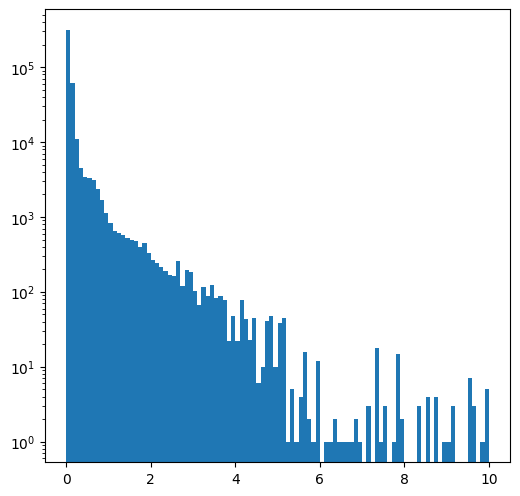

In [31]:
plt.hist(background["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

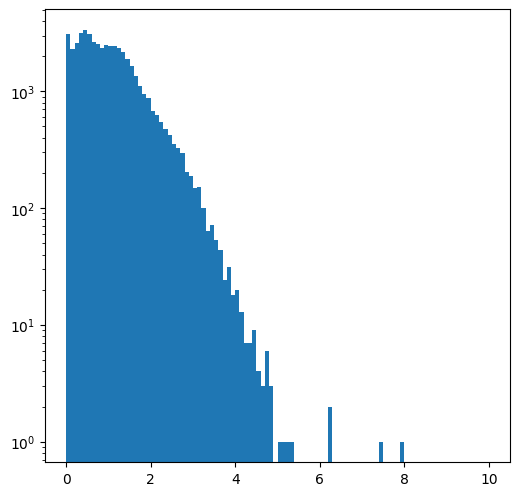

In [32]:
plt.hist(signal["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

The total number of events will be manually balanced

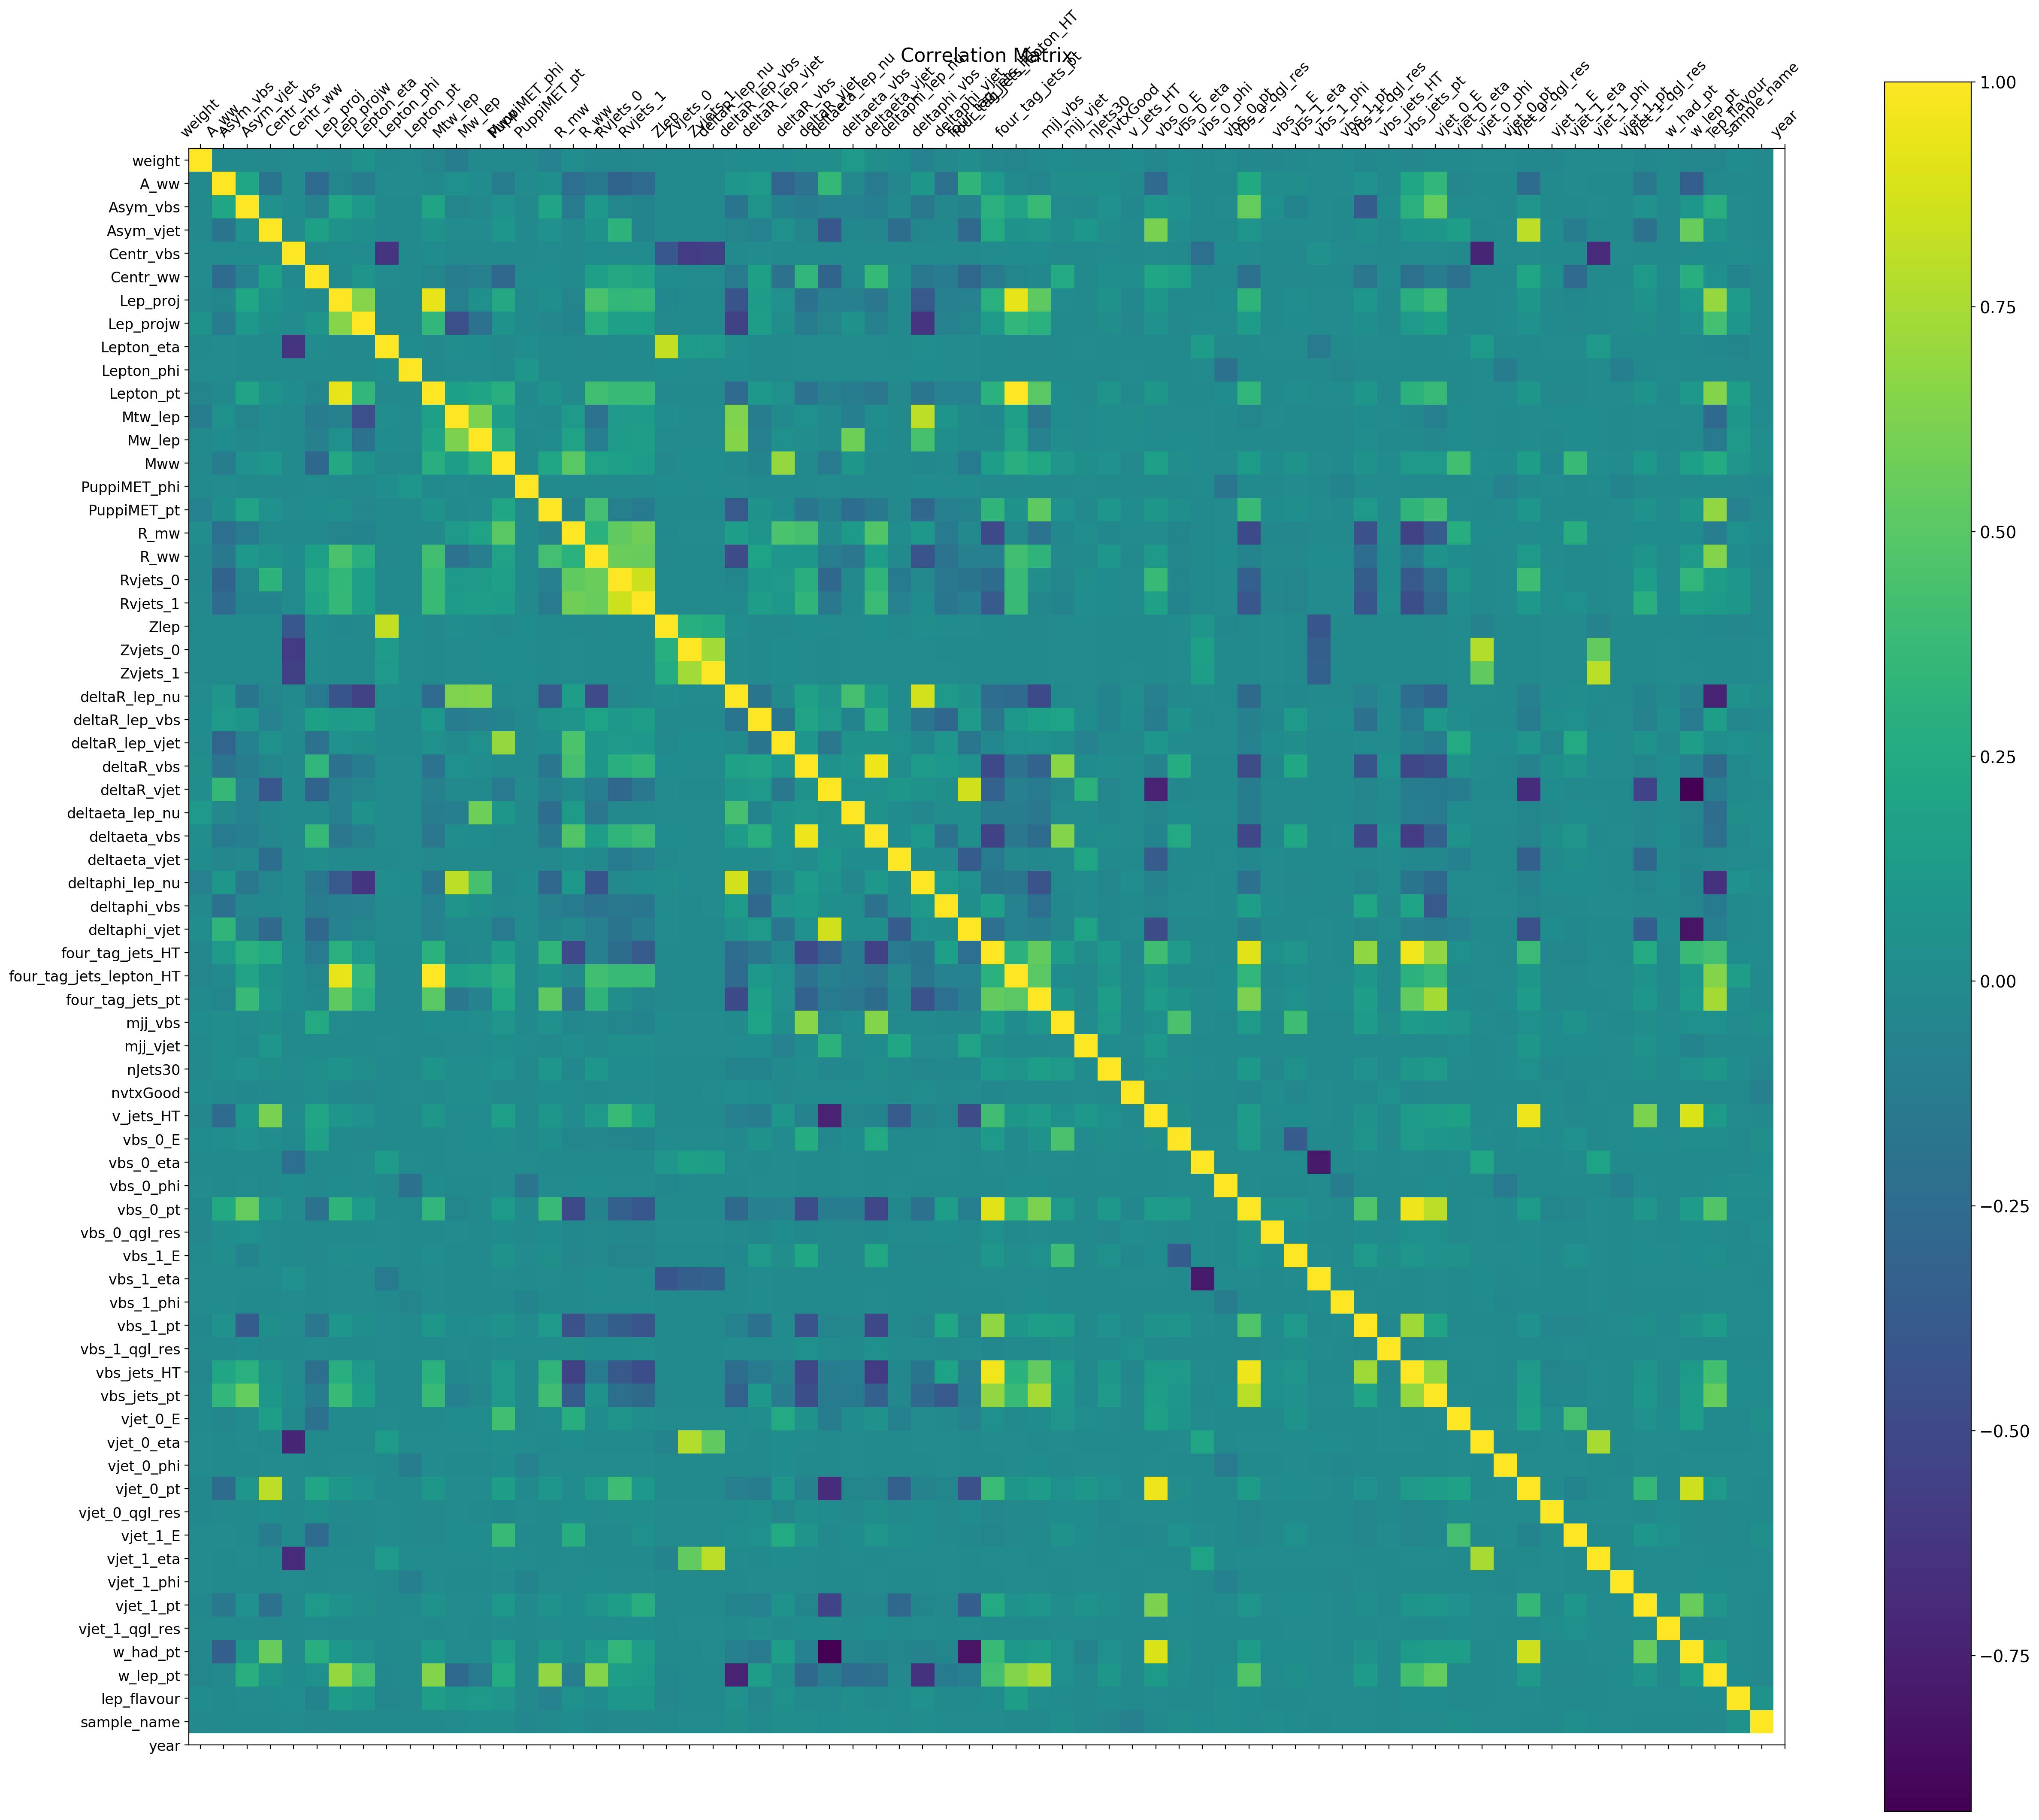

In [17]:
f = plt.figure(figsize=(30, 26), dpi=200)
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);